In [1]:
#this is the version with demos on the smaller sample !

In [2]:
import multiprocessing
import multiprocessing as mp

def get_num_cores():
    return multiprocessing.cpu_count()

if __name__ == '__main__':
    num_cores = get_num_cores()
    print("Number of CPU cores available:", num_cores)

from tqdm import tqdm
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pickle

import scipy.io
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.stats.multitest import multipletests

Number of CPU cores available: 32


In [3]:
#for the huge (>10 gb) MATLAB v7.3 file
with h5py.File('/home/ubuntu/data/full/full_only_before_sacc_sacclock_unfold_opticat.mat', 'r') as file:
    data = file['data'][:]

data = np.array(data)
data = data[:, :400, :]  # Slicing to take first 400 timepoints for sacc lock (before the saccade)
n_channels, n_timepoints, n_trials = data.shape
print(data.shape)  

#i want to have electrodes x timepoints x trials:
data = np.transpose(data, (2, 1, 0))
print(data.shape)  

############################################################

# second structure - tab
tab = pd.read_csv('/home/ubuntu/data/full/tab_199.csv')
tab = tab.drop('Dir', axis=1)
# Categorical conversion
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
print(tab.shape)  
print(tab.head())

(35475, 400, 105)
(105, 400, 35475)
(35475, 3)
  Condition   ID Age
0       pro  AA0   1
1       pro  AA0   1
2       pro  AA0   1
3       pro  AA0   1
4       pro  AA0   1


subset for "faster" iteration:

In [4]:
data = data[1:21,360:400,:]
data.shape

(20, 40, 35475)

In [5]:
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
n_channels, n_timepoints, n_trials = data.shape

In [6]:
def fit_model(channel, timepoint, data, tab):
    eeg_data = data[channel, timepoint, :]
    current_tab = tab.copy()
    current_tab['EEG'] = eeg_data
    formula = 'EEG ~ 1 + Condition * Age'
    current_tab['ID'] = current_tab['ID'].cat.codes
    model = smf.mixedlm(formula, current_tab, groups=current_tab['ID'])
    try:
        result = model.fit()
        return (channel, timepoint, result)
    except np.linalg.LinAlgError:
        return (channel, timepoint, "Model failed to converge")

def save_results(results, filename='model_results.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    results = {}
    pool = mp.Pool(processes=32) 
    jobs = []

    for channel in range(n_channels):
        for timepoint in range(n_timepoints):
            job = pool.apply_async(fit_model, args=(channel, timepoint, data, tab))
            jobs.append(job)

    pool.close()
    pool.join()

    for job in jobs:
        channel, timepoint, result = job.get()
        results[(channel, timepoint)] = result

In [7]:
 # Saving
custom_path = '/home/ubuntu/data/model_small_20electro_360_400points_results.pkl'
save_results(results, filename=custom_path)

In [8]:
def load_results(filename='/home/ubuntu/data/model_small_20electro_360_400points_results.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

custom_path = '/home/ubuntu/data/model_small_20electro_360_400points_results.pkl'
loaded_results = load_results(filename=custom_path)

In [9]:
print(loaded_results[(8, 8)].summary())  

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    EEG         
No. Observations:     35475      Method:                REML        
No. Groups:           199        Scale:                 70.0835     
Min. group size:      33         Log-Likelihood:        -125813.5329
Max. group size:      238        Converged:             Yes         
Mean group size:      178.3                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.194    0.112 -1.737 0.082 -0.412  0.025
Condition[T.pro]          -0.249    0.116 -2.149 0.032 -0.476 -0.022
Age[T.1]                   0.246    0.174  1.415 0.157 -0.095  0.587
Condition[T.pro]:Age[T.1]  0.511    0.181  2.819 0.005  0.156  0.866
Group Var                  0.645    0.012         

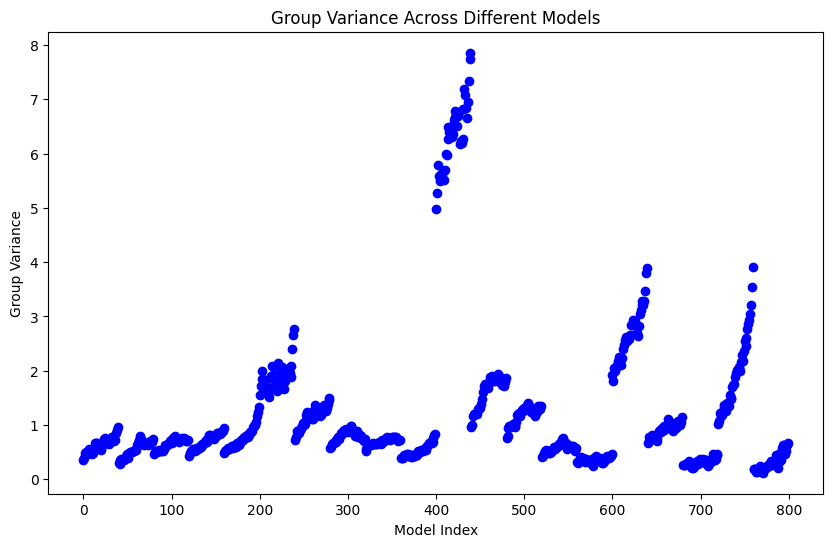

In [10]:
def extract_group_var(results):
    group_vars = {}
    for key, result in results.items():
        try:
            summary_str = result.summary().as_text()
            for line in summary_str.split('\n'):
                if 'Group Var' in line:
                    group_var_value = float(line.split()[2])  
                    group_vars[key] = group_var_value
                    break
        except Exception as e:
            print(f"Failed to extract for {key}: {str(e)}")
    return group_vars


def plot_group_vars(group_vars):
    # group variance values
    plt.figure(figsize=(10, 6))
    keys = list(group_vars.keys())
    values = [group_vars[key] for key in keys]
    plt.scatter(range(len(values)), values, color='blue')
    plt.xlabel('Model Index')
    plt.ylabel('Group Variance')
    plt.title('Group Variance Across Different Models')
    plt.show()


filename = '/home/ubuntu/data/model_small_20electro_360_400points_results.pkl'
results = load_results(filename)
group_vars = extract_group_var(results)
plot_group_vars(group_vars)


info reg convergence

In [11]:
def extract_convergence(results):
    convergence_status = {}
    for key, result in results.items():
        try:
            convergence_status[key] = 'Yes' if result.converged else 'No'
        except AttributeError:
            convergence_status[key] = 'Unknown'
        except Exception as e:
            print(f"Failed to extract for {key}: {str(e)}")
    return convergence_status

filename = '/home/ubuntu/data/model_small_20electro_360_400points_results.pkl'
results = load_results(filename)
convergence = extract_convergence(results)
print(convergence)


{(0, 0): 'Yes', (0, 1): 'Yes', (0, 2): 'Yes', (0, 3): 'Yes', (0, 4): 'Yes', (0, 5): 'Yes', (0, 6): 'Yes', (0, 7): 'Yes', (0, 8): 'Yes', (0, 9): 'Yes', (0, 10): 'Yes', (0, 11): 'Yes', (0, 12): 'Yes', (0, 13): 'Yes', (0, 14): 'Yes', (0, 15): 'Yes', (0, 16): 'Yes', (0, 17): 'Yes', (0, 18): 'Yes', (0, 19): 'Yes', (0, 20): 'Yes', (0, 21): 'Yes', (0, 22): 'Yes', (0, 23): 'Yes', (0, 24): 'Yes', (0, 25): 'Yes', (0, 26): 'Yes', (0, 27): 'Yes', (0, 28): 'Yes', (0, 29): 'Yes', (0, 30): 'Yes', (0, 31): 'Yes', (0, 32): 'Yes', (0, 33): 'Yes', (0, 34): 'Yes', (0, 35): 'Yes', (0, 36): 'Yes', (0, 37): 'Yes', (0, 38): 'Yes', (0, 39): 'Yes', (1, 0): 'Yes', (1, 1): 'Yes', (1, 2): 'Yes', (1, 3): 'Yes', (1, 4): 'Yes', (1, 5): 'Yes', (1, 6): 'Yes', (1, 7): 'Yes', (1, 8): 'Yes', (1, 9): 'Yes', (1, 10): 'Yes', (1, 11): 'Yes', (1, 12): 'Yes', (1, 13): 'Yes', (1, 14): 'Yes', (1, 15): 'Yes', (1, 16): 'Yes', (1, 17): 'Yes', (1, 18): 'Yes', (1, 19): 'Yes', (1, 20): 'Yes', (1, 21): 'Yes', (1, 22): 'Yes', (1, 23): 'Y

In [12]:

def extract_pvalues(results):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues['Condition[T.pro]:Age[T.1]']
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for (Channel {channel}, Timepoint {timepoint})")

    return pvalues


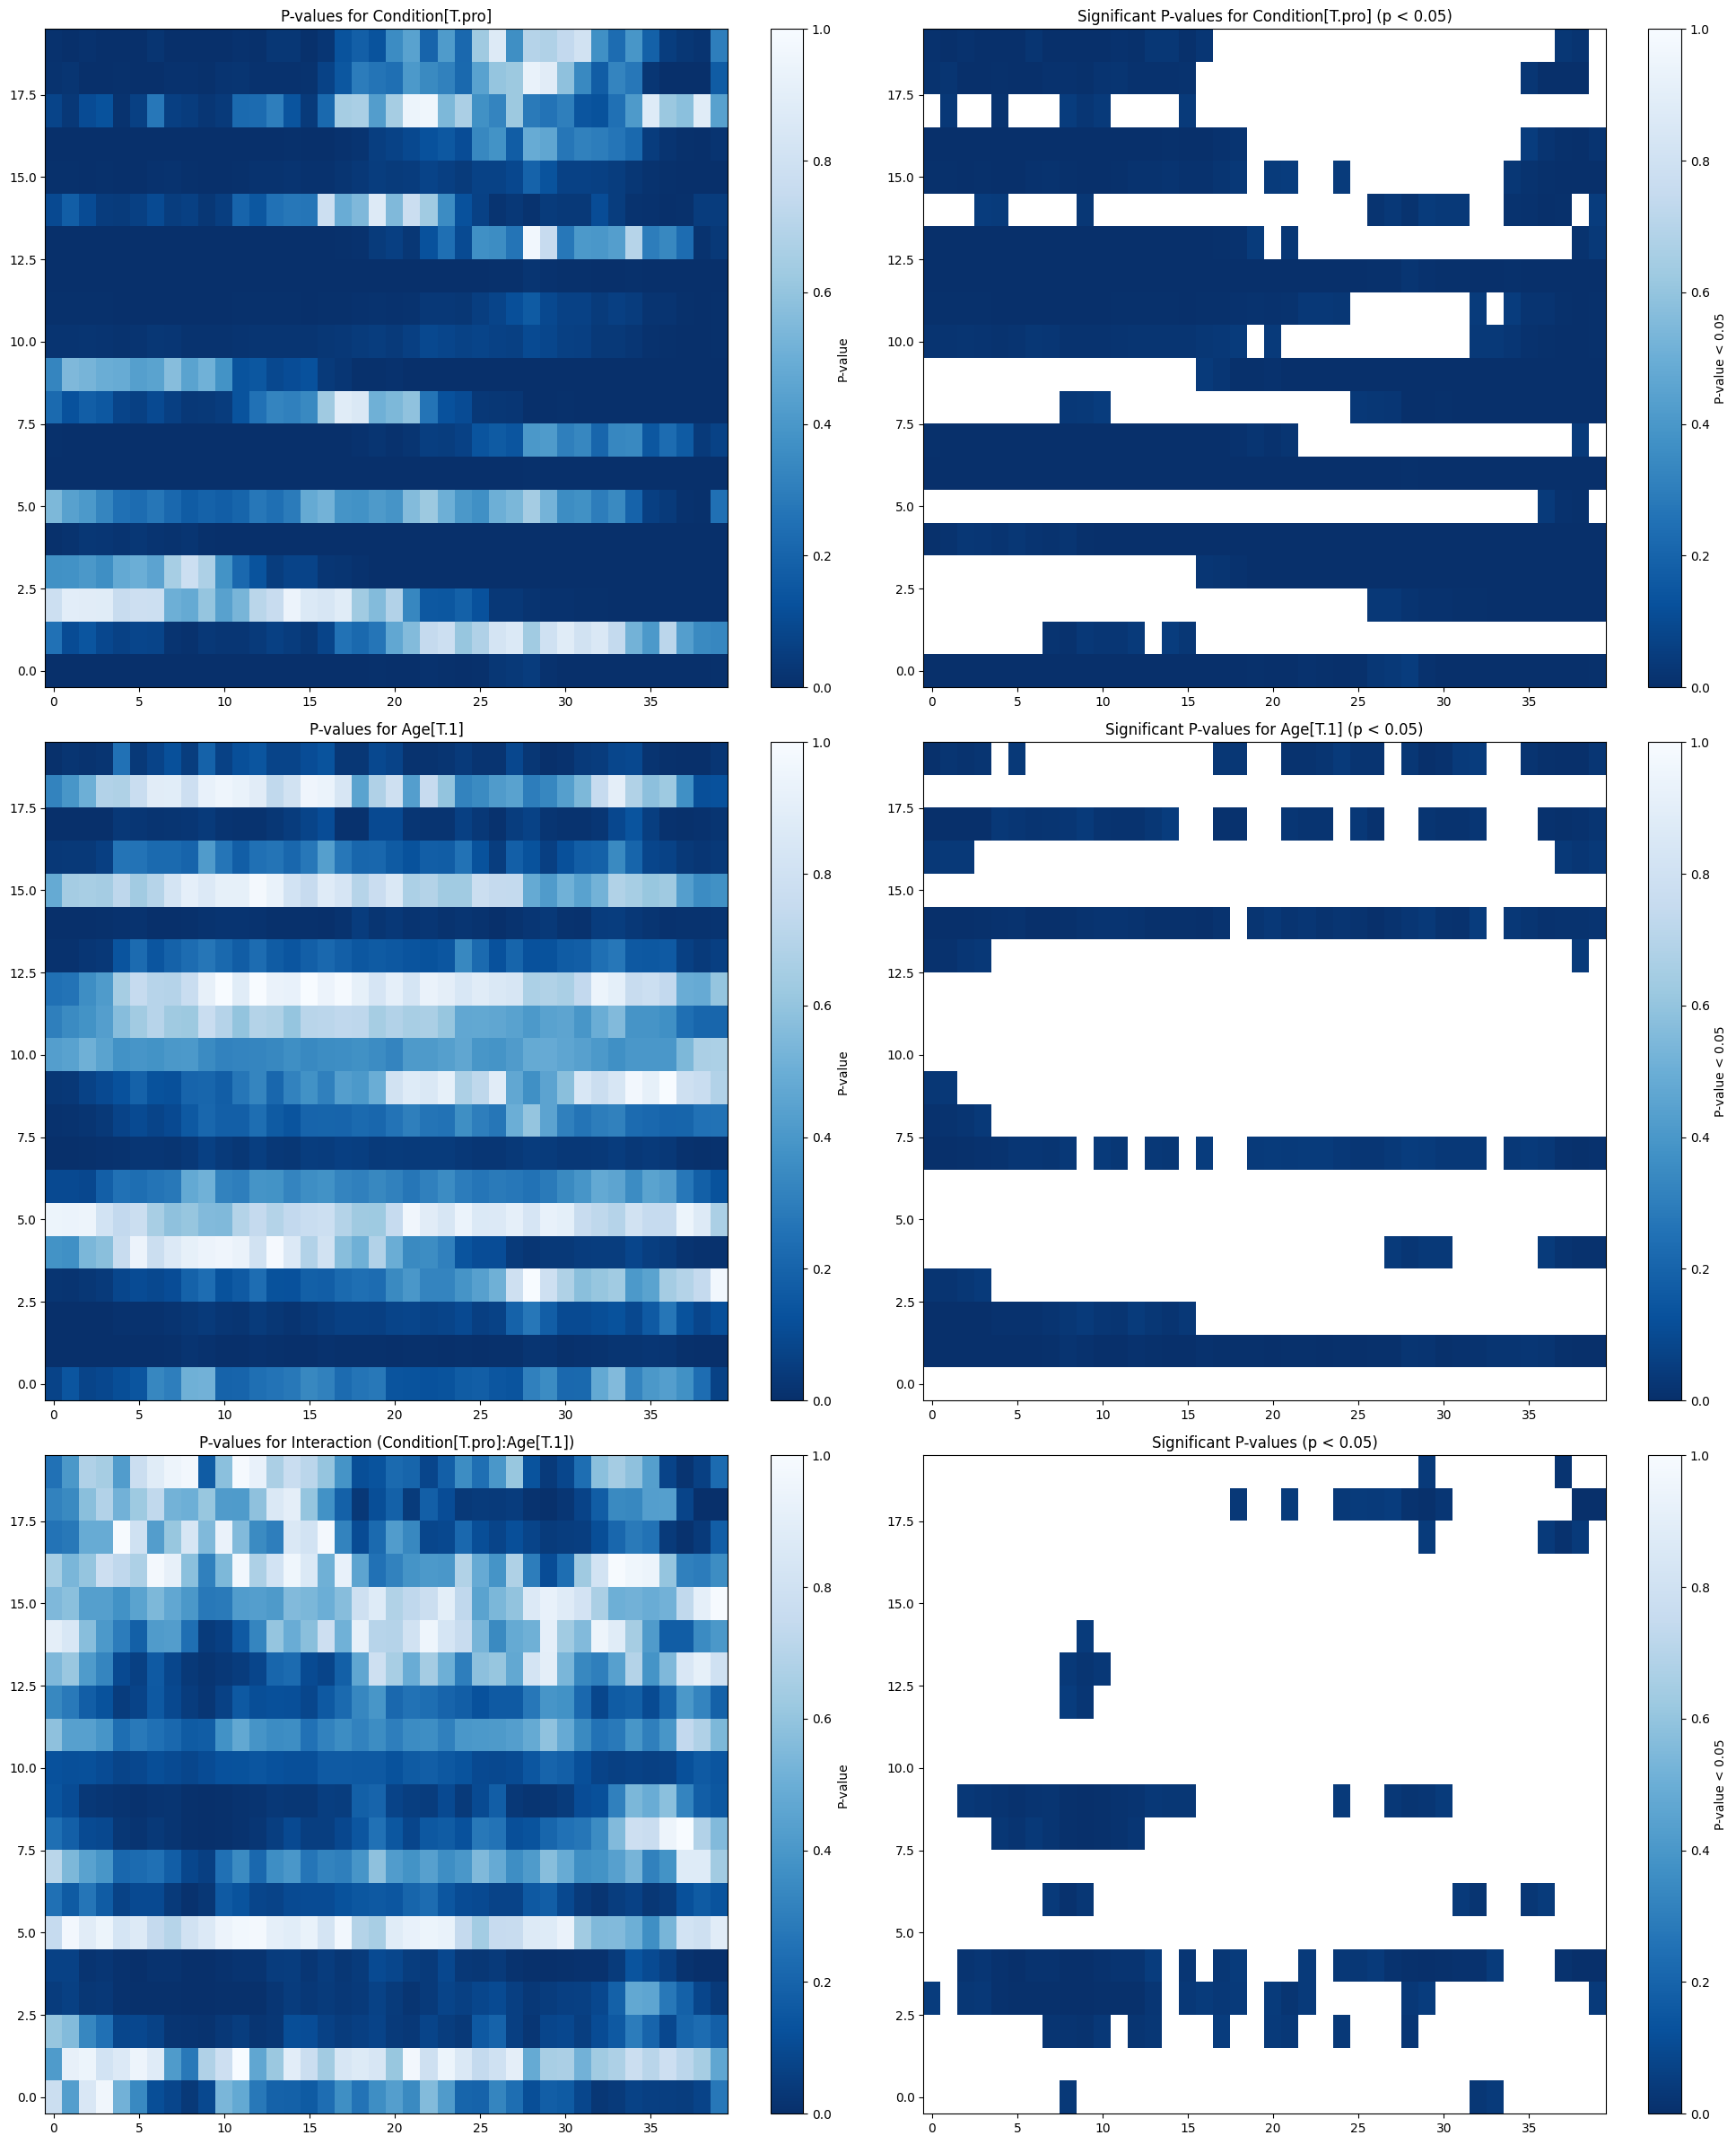

In [13]:

def plot_complex_pvalues(results):
    plt.figure(figsize=(20, 24))  #  3 rows and 2 columns of plots

    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Condition[T.pro]
    ax1 = plt.subplot(3, 2, 1)
    cax1 = ax1.imshow(pvalues_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax1, ax=ax1, label='P-value')
    ax1.set_title('P-values for Condition[T.pro]')

    ax2 = plt.subplot(3, 2, 2)
    significant_cond = np.where(pvalues_cond < 0.05, pvalues_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax2, ax=ax2, label='P-value < 0.05')
    ax2.set_title('Significant P-values for Condition[T.pro] (p < 0.05)')

    # Age[T.1]
    ax3 = plt.subplot(3, 2, 3)
    cax3 = ax3.imshow(pvalues_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax3, ax=ax3, label='P-value')
    ax3.set_title('P-values for Age[T.1]')

    ax4 = plt.subplot(3, 2, 4)
    significant_age = np.where(pvalues_age < 0.05, pvalues_age, np.nan)
    cax4 = ax4.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax4, ax=ax4, label='P-value < 0.05')
    ax4.set_title('Significant P-values for Age[T.1] (p < 0.05)')

    # Interaction
    ax5 = plt.subplot(3, 2, 5)
    cax5 = ax5.imshow(pvalues_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax5, ax=ax5, label='P-value')
    ax5.set_title('P-values for Interaction (Condition[T.pro]:Age[T.1])')

    ax6 = plt.subplot(3, 2, 6)
    significant_interaction = np.where(pvalues_interaction < 0.05, pvalues_interaction, np.nan)
    cax6 = ax6.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax6, ax=ax6, label='P-value < 0.05')
    ax6.set_title('Significant P-values (p < 0.05)')

    plt.tight_layout()  
    plt.show()

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)


plot_complex_pvalues(results)


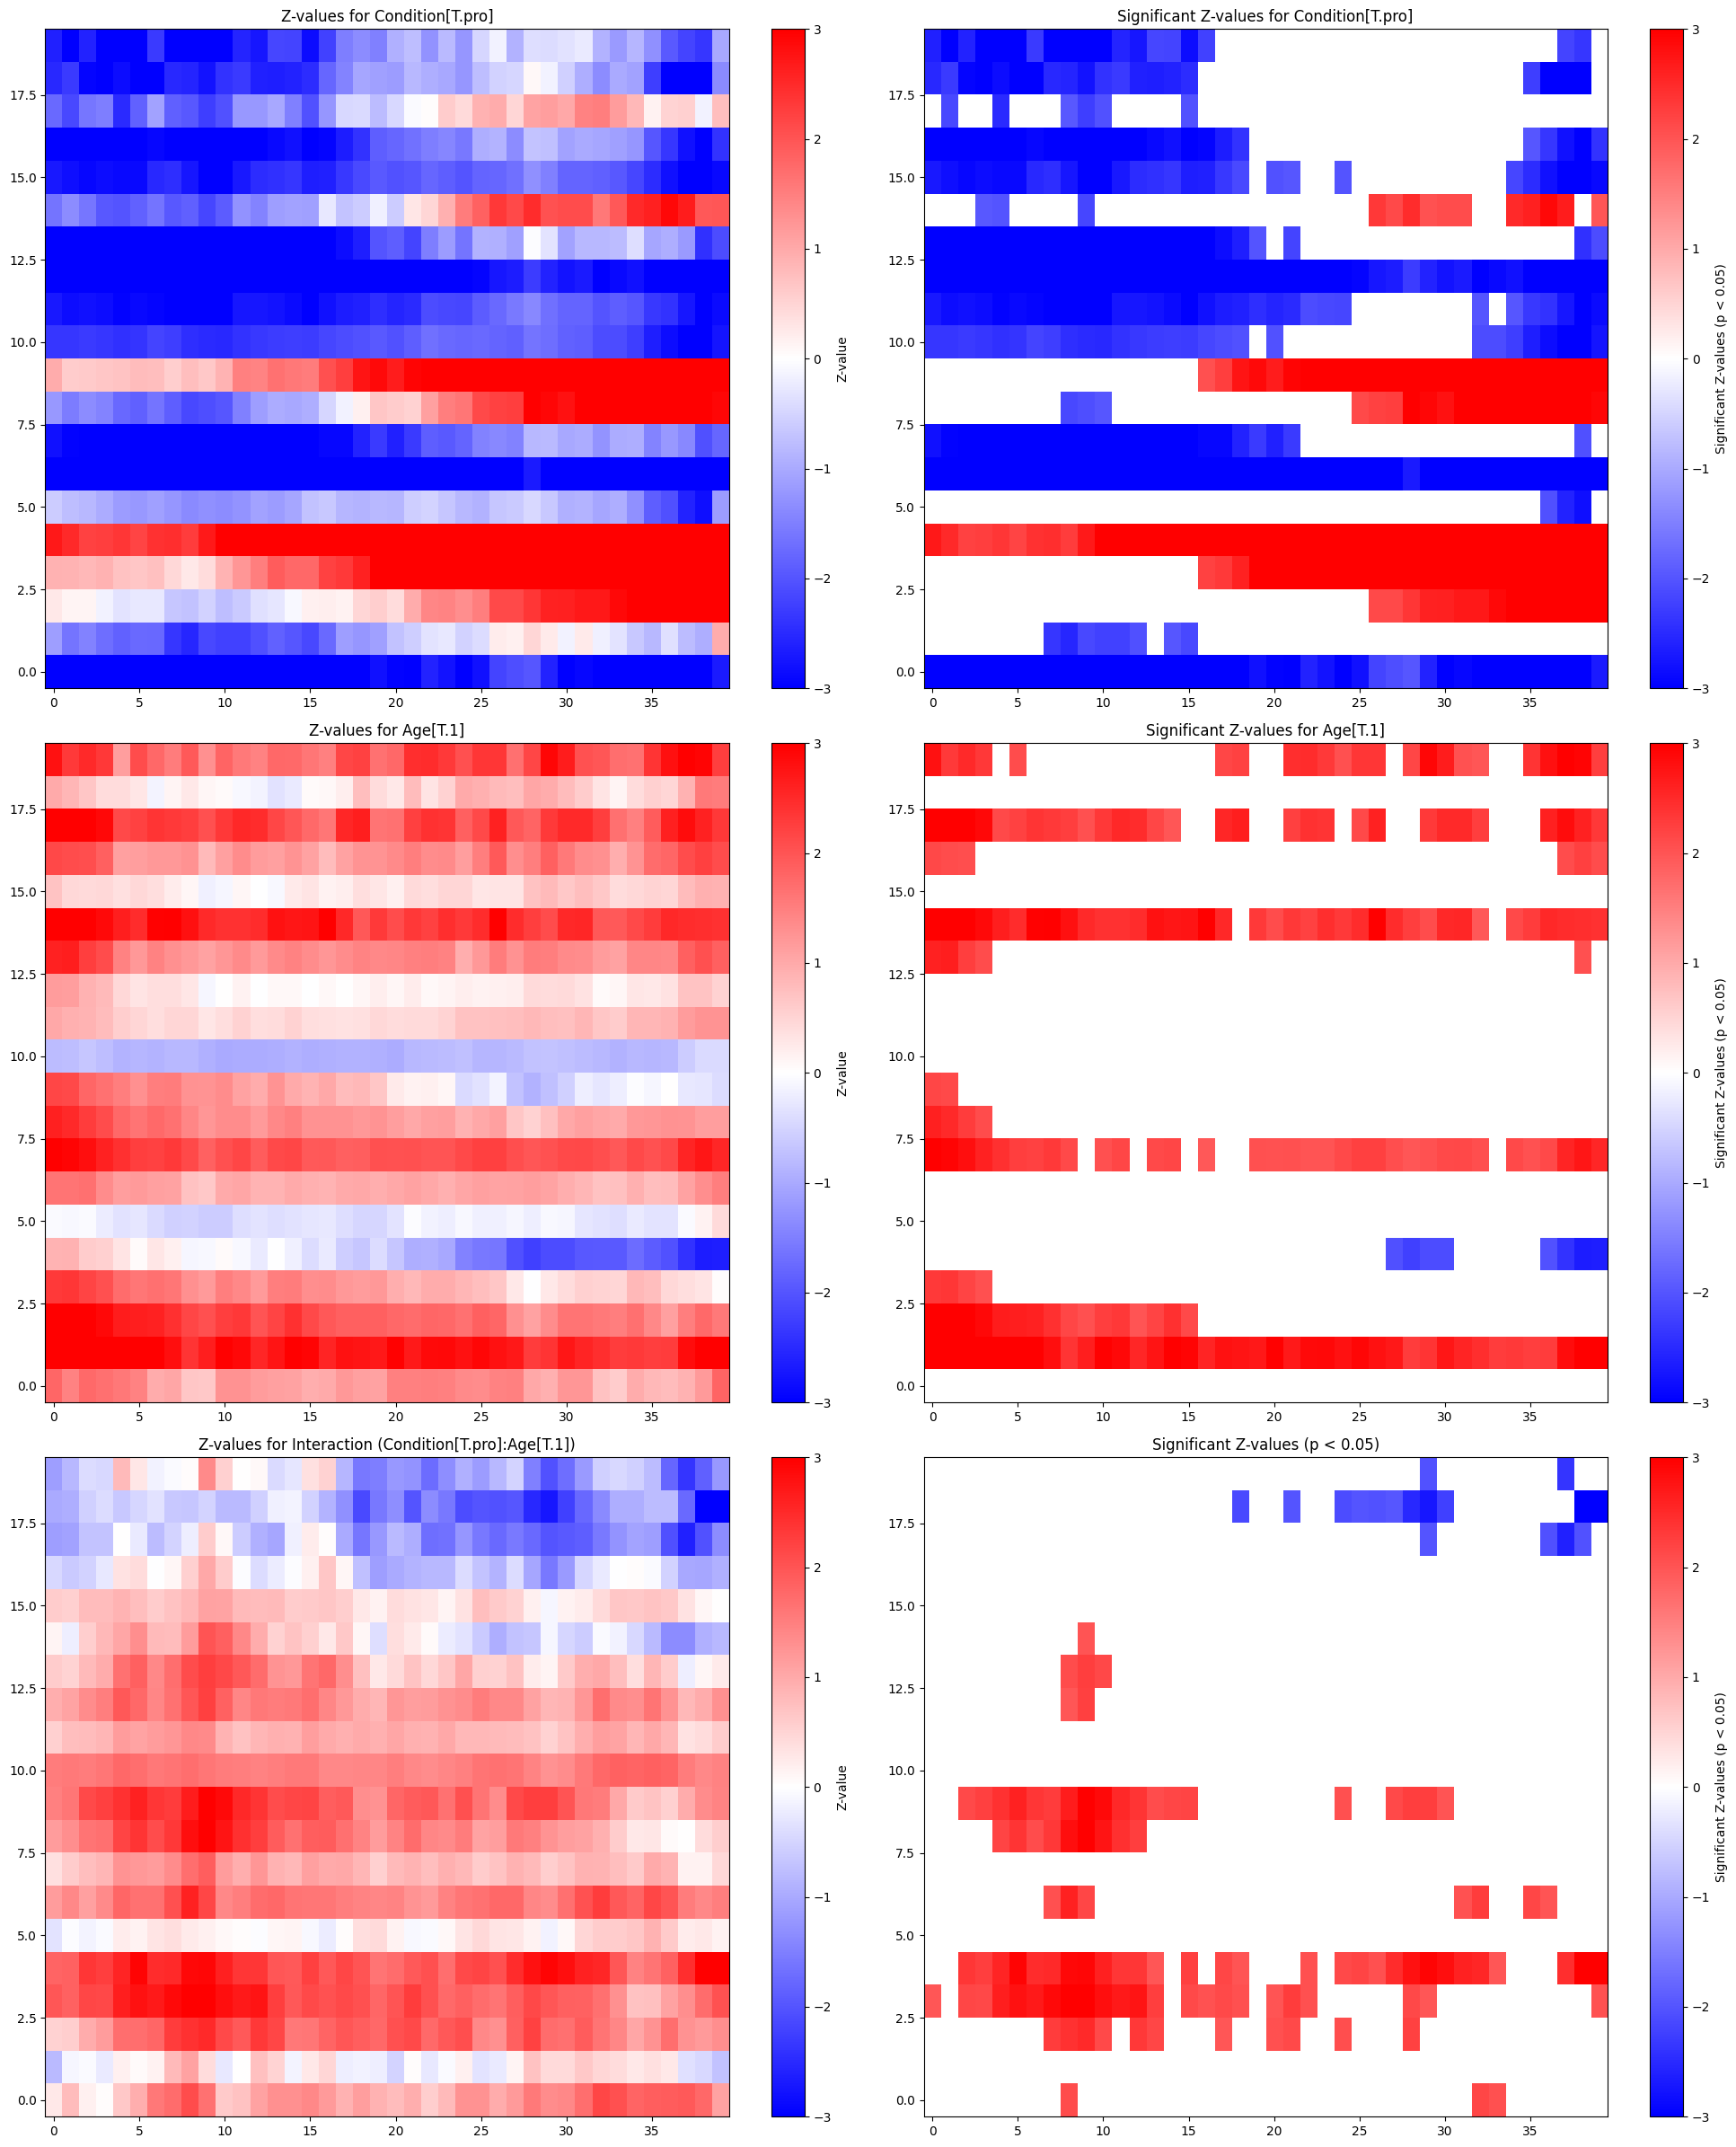

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_zvalues(results):
    plt.figure(figsize=(20, 24))  
    # Extracting z-values
    zvalues_cond = extract_zvalues(results, 'Condition[T.pro]')
    zvalues_age = extract_zvalues(results, 'Age[T.1]')
    zvalues_interaction = extract_zvalues(results, 'Condition[T.pro]:Age[T.1]')
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Condition[T.pro]
    ax1 = plt.subplot(3, 2, 1)
    cax1 = ax1.imshow(zvalues_cond, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax1, ax=ax1, label='Z-value')
    ax1.set_title('Z-values for Condition[T.pro]')

    ax2 = plt.subplot(3, 2, 2)
    significant_cond = np.where(pvalues_cond < 0.05, zvalues_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax2, ax=ax2, label='Significant Z-values (p < 0.05)')
    ax2.set_title('Significant Z-values for Condition[T.pro]')

    # Age[T.1]
    ax3 = plt.subplot(3, 2, 3)
    cax3 = ax3.imshow(zvalues_age, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax3, ax=ax3, label='Z-value')
    ax3.set_title('Z-values for Age[T.1]')

    ax4 = plt.subplot(3, 2, 4)
    significant_age = np.where(pvalues_age < 0.05, zvalues_age, np.nan)
    cax4 = ax4.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax4, ax=ax4, label='Significant Z-values (p < 0.05)')
    ax4.set_title('Significant Z-values for Age[T.1]')

    # Interaction
    ax5 = plt.subplot(3, 2, 5)
    cax5 = ax5.imshow(zvalues_interaction, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax5, ax=ax5, label='Z-value')
    ax5.set_title('Z-values for Interaction (Condition[T.pro]:Age[T.1])')

    ax6 = plt.subplot(3, 2, 6)
    significant_interaction = np.where(pvalues_interaction < 0.05, zvalues_interaction, np.nan)
    cax6 = ax6.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax6, ax=ax6, label='Significant Z-values (p < 0.05)')
    ax6.set_title('Significant Z-values (p < 0.05)')

    plt.tight_layout()
    plt.show()

def extract_zvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    zvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            z_value = result.tvalues[term]  
            zvalues[channel, timepoint] = z_value
        except (KeyError, AttributeError):
            print(f"Missing z-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return zvalues


plot_complex_zvalues(results)


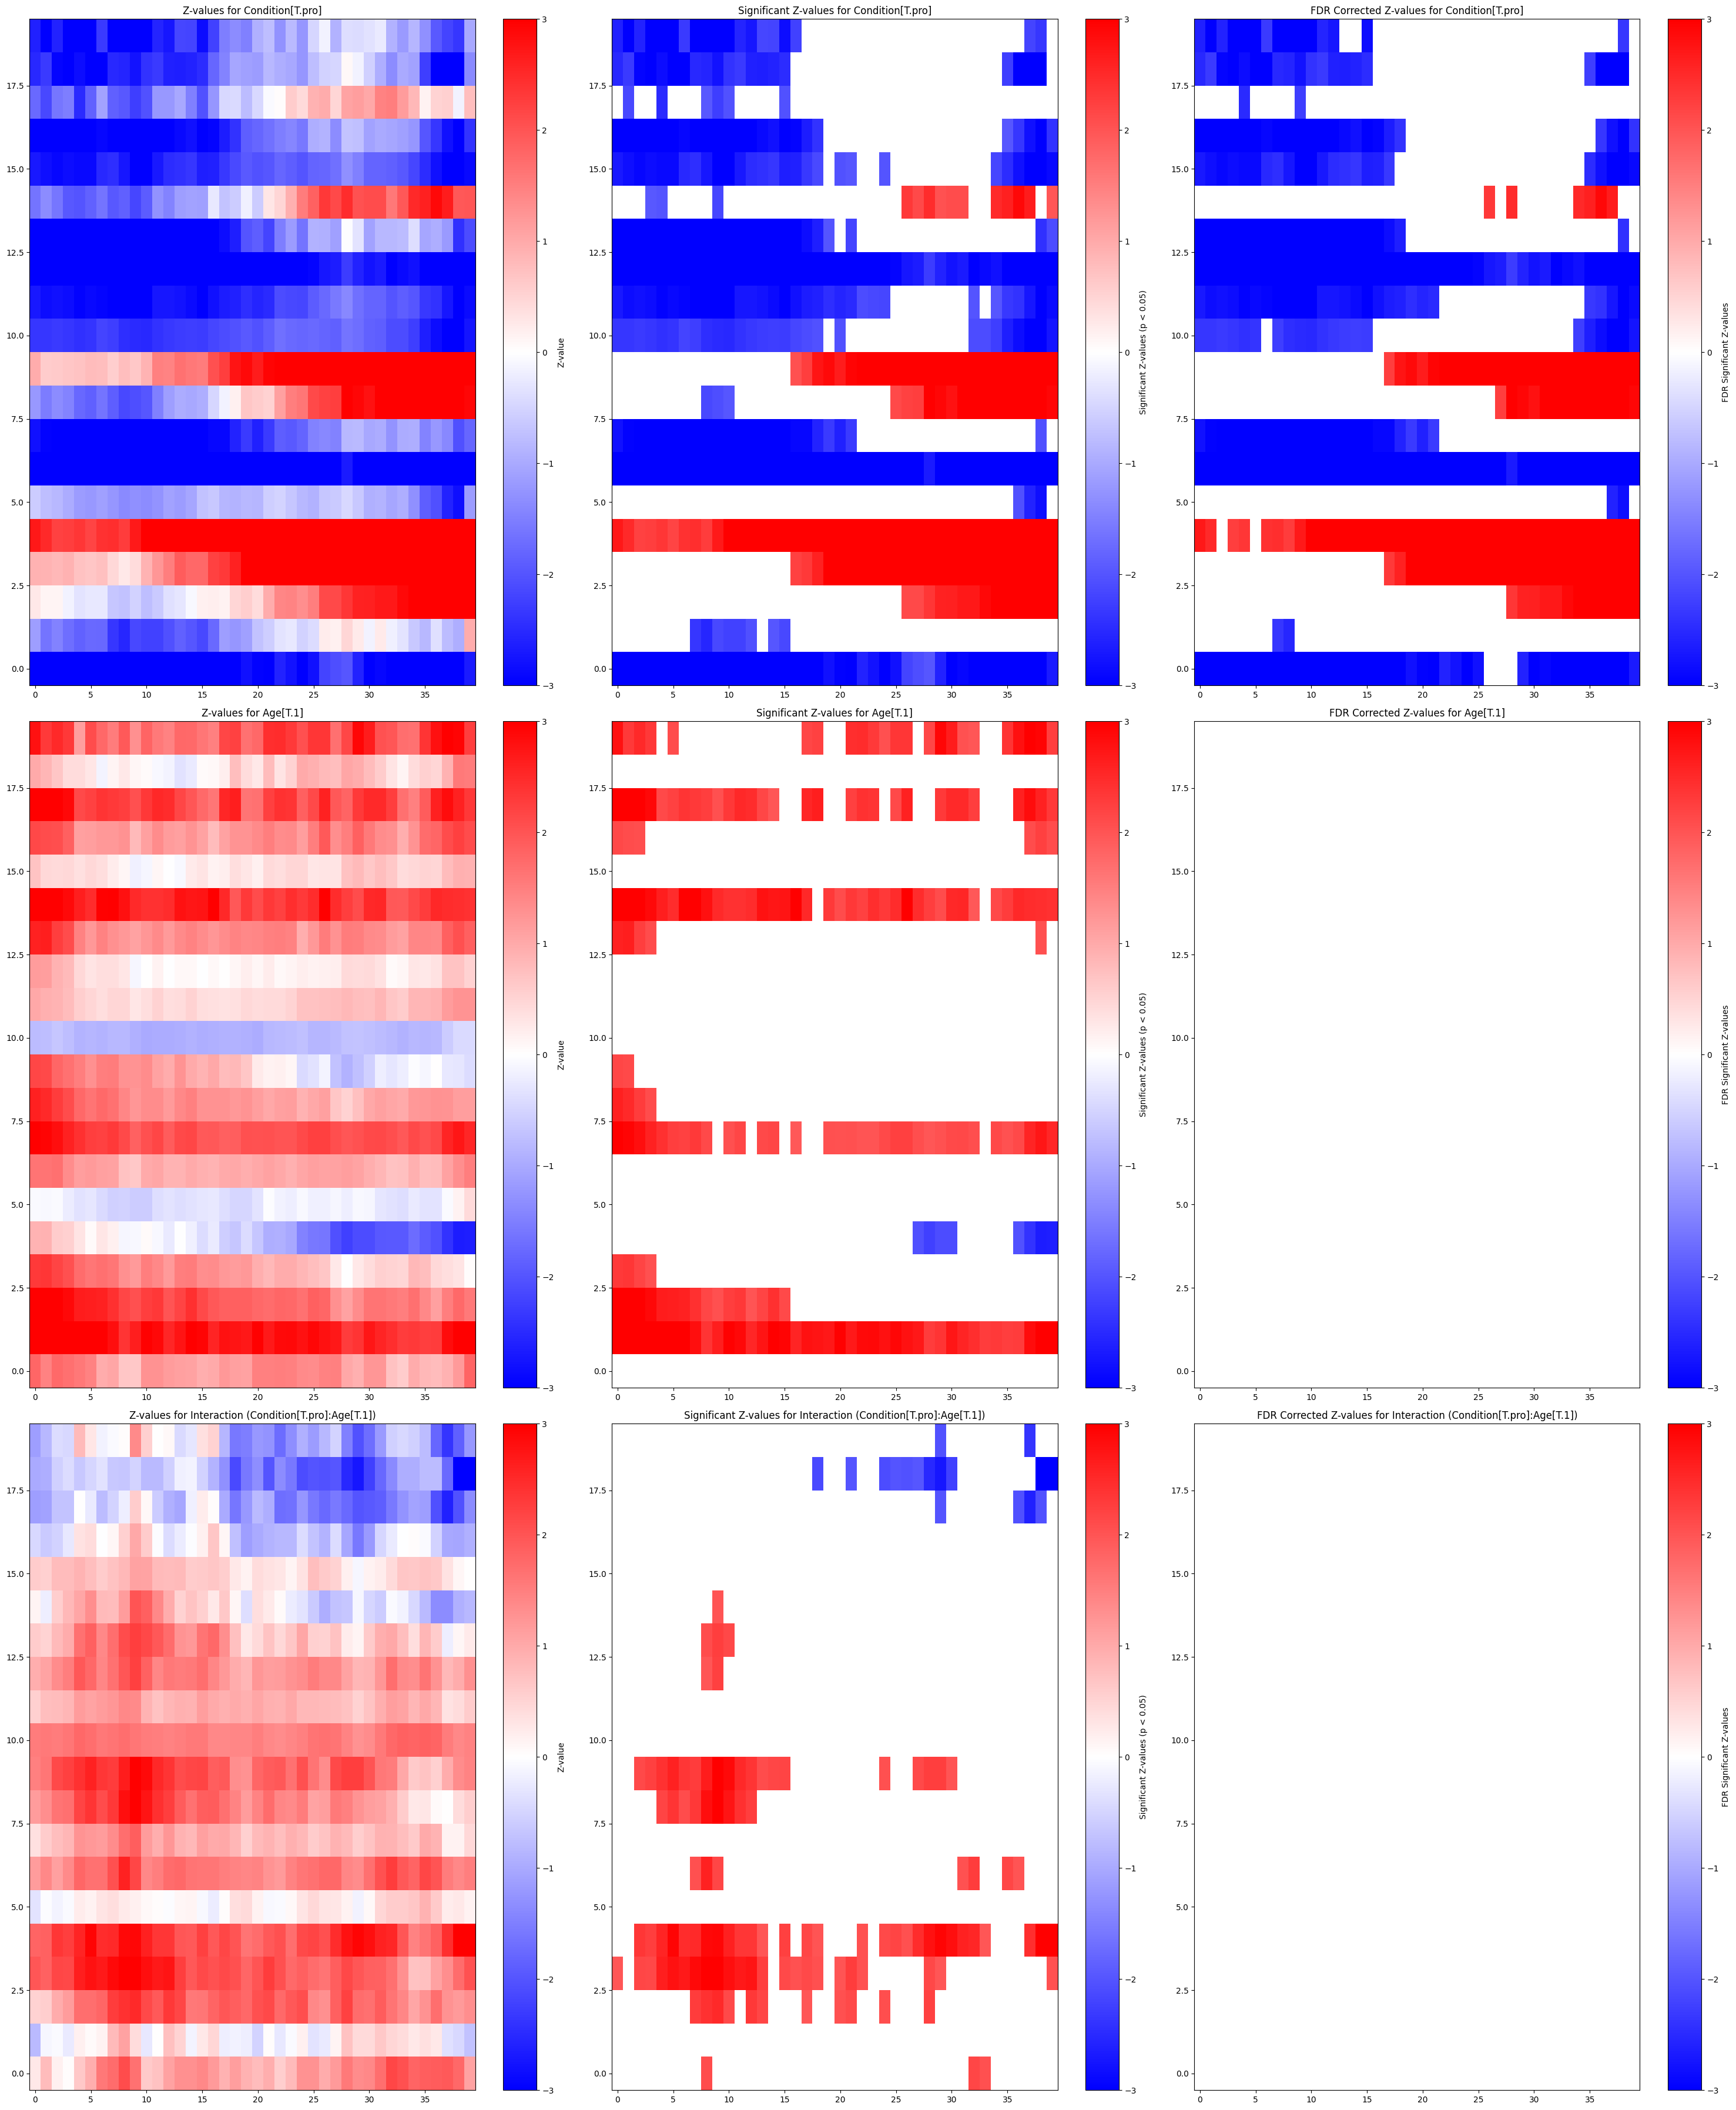

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.multitest as smm

def plot_complex_zvalues_fdr(results):
    plt.figure(figsize=(30, 36))  

    # Extracting z-values and p-values
    zvalues_cond = extract_zvalues(results, 'Condition[T.pro]')
    zvalues_age = extract_zvalues(results, 'Age[T.1]')
    zvalues_interaction = extract_zvalues(results, 'Condition[T.pro]:Age[T.1]')
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Applying FDR correction
    fdr_cond = smm.multipletests(pvalues_cond.flatten(), method='fdr_bh')[1].reshape(pvalues_cond.shape)
    fdr_age = smm.multipletests(pvalues_age.flatten(), method='fdr_bh')[1].reshape(pvalues_age.shape)
    fdr_interaction = smm.multipletests(pvalues_interaction.flatten(), method='fdr_bh')[1].reshape(pvalues_interaction.shape)

    # Create subplots for each variable and its significant values
    plot_zvalues(zvalues_cond, pvalues_cond, fdr_cond, 1, 'Condition[T.pro]')
    plot_zvalues(zvalues_age, pvalues_age, fdr_age, 4, 'Age[T.1]')
    plot_zvalues(zvalues_interaction, pvalues_interaction, fdr_interaction, 7, 'Interaction (Condition[T.pro]:Age[T.1])')

    plt.tight_layout()
    plt.show()

def plot_zvalues(zvalues, pvalues, fdr_values, start_idx, title):
    axes = [plt.subplot(3, 3, i) for i in range(start_idx, start_idx + 3)]
    # Original Z-values
    cax = axes[0].imshow(zvalues, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax, ax=axes[0], label='Z-value')
    axes[0].set_title(f'Z-values for {title}')

    # Significant Z-values (original p-values)
    significant_z = np.where(pvalues < 0.05, zvalues, np.nan)
    cax_sig = axes[1].imshow(significant_z, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax_sig, ax=axes[1], label='Significant Z-values (p < 0.05)')
    axes[1].set_title(f'Significant Z-values for {title}')

    # FDR corrected significant Z-values
    fdr_sig_z = np.where(fdr_values < 0.05, zvalues, np.nan)
    cax_fdr = axes[2].imshow(fdr_sig_z, aspect='auto', interpolation='none', origin='lower', cmap='bwr', vmin=-3, vmax=3)
    plt.colorbar(cax_fdr, ax=axes[2], label='FDR Significant Z-values')
    axes[2].set_title(f'FDR Corrected Z-values for {title}')

def extract_zvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    zvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            z_value = result.tvalues[term] 
            zvalues[channel, timepoint] = z_value
        except (KeyError, AttributeError):
            print(f"Missing z-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return zvalues

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)


plot_complex_zvalues_fdr(results)


Below, we apply False Discovery Rate (FDR) correction across timepoints while keeping the channel dimension uncorrected.

underlying assumption: Comparisons across timepoints are where the multiplicity issues lie, and that channels are to be treated independently.

In [ ]:
#modified version of the FDR:

def plot_complex_zvalues_fdr(results):
    plt.figure(figsize=(30, 36))  

    # Extracting z-values and p-values
    zvalues_cond = extract_zvalues(results, 'Condition[T.pro]')
    zvalues_age = extract_zvalues(results, 'Age[T.1]')
    zvalues_interaction = extract_zvalues(results, 'Condition[T.pro]:Age[T.1]')
    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Applying FDR correction only across timepoints
    fdr_cond = np.array([smm.multipletests(pvalues_cond[channel,:].flatten(), method='fdr_bh')[1]
                         for channel in range(pvalues_cond.shape[0])]).reshape(pvalues_cond.shape)
    fdr_age = np.array([smm.multipletests(pvalues_age[channel,:].flatten(), method='fdr_bh')[1]
                        for channel in range(pvalues_age.shape[0])]).reshape(pvalues_age.shape)
    fdr_interaction = np.array([smm.multipletests(pvalues_interaction[channel,:].flatten(), method='fdr_bh')[1]
                                for channel in range(pvalues_interaction.shape[0])]).reshape(pvalues_interaction.shape)

    #  subplots for each variable and its significant values
    plot_zvalues(zvalues_cond, pvalues_cond, fdr_cond, 1, 'Condition[T.pro]')
    plot_zvalues(zvalues_age, pvalues_age, fdr_age, 4, 'Age[T.1]')
    plot_zvalues(zvalues_interaction, pvalues_interaction, fdr_interaction, 7, 'Interaction (Condition[T.pro]:Age[T.1])')

    plt.tight_layout()
    plt.show()
